In [1]:
import anndata
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score

In [2]:
ad = anndata.read_h5ad('../output/adata.h5ad')
# add color coding
colors = {}
colors['HSC'] = '#ffffb2'
colors['MPP'] = '#fecc5c'
colors['LMPP'] = '#a1dab4'
colors['CLP'] = '#238443'
colors['pDC'] = '#225ea8'
colors['CMP'] = '#ef6548'
colors['GMP'] = '#cc4c02'
colors['MEP'] = '#e31a1c'
colors['mono'] = '#6a51a3'
colors['UNK'] = 'gray'
ad.uns["label_colors"] = [colors[i] for i in ad.obs['label'].cat.categories]

### find the topic that best correlate with batch and remove it

In [3]:
dims = ad.obsm['latent']
ad.obsm['projection'] = dims
sc.pp.neighbors(ad, use_rep='projection')
sc.tl.tsne(ad, use_rep='projection')

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


In [4]:
batch_code = pd.get_dummies(ad.obs['batch'])['BM0828']
aucs = []
for i in range(dims.shape[1]):
    a = roc_auc_score(batch_code, dims[:,i])
    b = roc_auc_score(1-batch_code, dims[:,i])
    aucs +=[np.max([a,b])]
indices = np.argsort(aucs)[::-1]

In [ ]:
f, axs = plt.subplots(nrows=2, ncols=4, figsize=(15, 6))
for i in range(8):
    var_name = 'topic_%d'%indices[i]
    ad.obs[var_name] = dims[:,indices[i]]
    row = int(i/4)
    col = i%4
    sc.pl.tsne(ad, color=var_name, ax=axs[row][col], show=False)
f.tight_layout()
f.savefig('select_batch_dim.pdf')

### plot batch corrected t-SNE

In [ ]:
f, axs = plt.subplots(nrows=2, ncols=4, figsize=(15, 6))
for i in range(8):
    select = np.isin(np.arange(10), indices[:(i+1)])
    dims_new = dims[:, ~select]
    ad.obsm['projection'] = dims_new
    sc.pp.neighbors(ad, use_rep='projection')
    sc.tl.tsne(ad, use_rep='projection')
    row = int(i/4)
    col = i%4
    sc.pl.tsne(ad, color='label', ax=axs[row][col], show=False)
    axs[row][col].set_title('exclude top %d dims' %(i+1))
f.tight_layout()
f.savefig('select_batch_tsne.pdf')

### save batch corrected embeddings

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


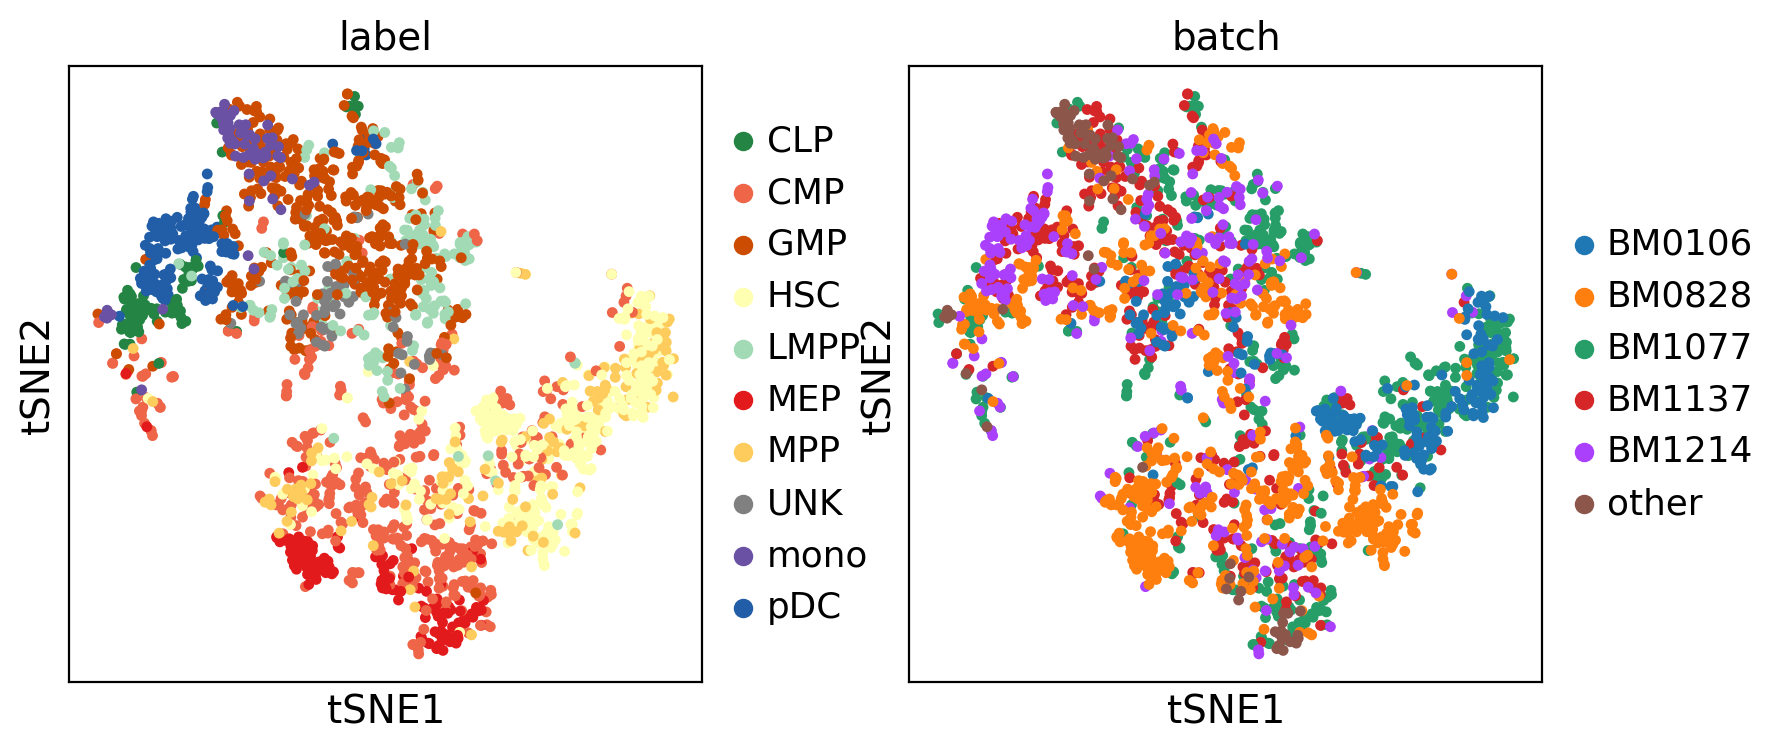

In [5]:
i = 3
select = np.isin(np.arange(10), indices[:(i+1)])
dim_new = dims[:, ~select]
pd.DataFrame(dim_new).to_csv('projection_bc.csv')

sc.set_figure_params(vector_friendly=True, format='pdf', dpi=100)
ad.obsm['projection'] = dim_new
sc.pp.neighbors(ad, use_rep='projection')
sc.tl.tsne(ad, use_rep='projection')
f = sc.pl.tsne(ad, color=['label','batch'], return_fig=True)
f.savefig('tsne_bc.pdf')